In [1]:
fidx = 'preresnet'
midx = '0'

import numpy as np
import pandas as pd

np.set_printoptions(precision=3, suppress=True, linewidth=100)

mnames, weights = ['preresnet_u67'], [1]

# mnames, weights = blend3(mnames18,weights18,mnames19,weights19,mnames2,weights2)

# print(mnames)

threshold = 0.34
nfold = 20

sub_dir = './sub/'

print(fidx,midx,threshold,nfold)

order = np.argsort(-np.array(weights))
for i in range(len(weights)):
    print('%5.3f' % weights[order[i]],mnames[order[i]])

# for m,w in zip(mnames,weights):
#     print('%6.4f' % w,m)

print('sum of weights','%5.3f' % (sum(np.array(weights))))
# assert(len(mnames)==len(weights))

preresnet 0 0.34 20
1.000 preresnet_u67
sum of weights 1.000


In [2]:
glist = ['iv3_b6','iv3_b9','irv2_b8','nas_b7',
         'gap_c9','preresnet_u67',
         'resnet_q25','resnet_q26','resnet_q27',
         'resnet_q40','resnet_u25','resnet_u31','resnet_u56',
         'se_resnet_b24',
         'se_resnext_e15','se_resnext_e16','se_resnext_e17']
blist = ['blend_0459']
tlist = ['iv3_a4','se_resnext_d10','se_resnext_d11']
klist = ['resnet34_46','resnet50','resnet34']
print(glist)
print(blist)
print(tlist)
print(klist)

gpct = 95.
gscale = 10.

['iv3_b6', 'iv3_b9', 'irv2_b8', 'nas_b7', 'gap_c9', 'preresnet_u67', 'resnet_q25', 'resnet_q26', 'resnet_q27', 'resnet_q40', 'resnet_u25', 'resnet_u31', 'resnet_u56', 'se_resnet_b24', 'se_resnext_e15', 'se_resnext_e16', 'se_resnext_e17']
['blend_0459']
['iv3_a4', 'se_resnext_d10', 'se_resnext_d11']
['resnet34_46', 'resnet50', 'resnet34']


In [3]:
import numpy as np
import pandas as pd
import pickle
import os
from os import path
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize

from scipy.special import logit, expit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_similarity_score, f1_score

import scipy.optimize as opt

import gc
import cv2
from tqdm import tqdm_notebook

from numpy import inf

/home/sasrdw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
LABEL_MAP = name_label_dict
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [5]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [6]:
# test_df["images"] = [np.array(load_img("images/{}.png".format(idx), \
#                                         color_mode = "grayscale")) / 255. \
#                                         # grayscale=True)) / 255. \
#                       for idx in tqdm_notebook(test_df.index)]
# print(test_df.shape)

In [7]:
test_df.columns

Index(['Predicted'], dtype='object')

In [8]:
# save a base copy for reuse below
test_df0 = test_df.copy()


In [9]:
# build submission ensemble as weighted average on logit scale
test_df = test_df0.copy()
idx = test_df.index.values

firstm = True
sumw = 0.

for m in mnames:

    firstf = True
    if m in blist: suffix = '.npy'
    elif m in klist: suffix = '.pkl'
    else: suffix = '_mm.pkl'
    for fold in range(nfold):
#         print('')
#         print(m+'_'+str(fold))
        first = True
        nr = 0
        for rep in ['','a','b','c','d','e','f','g','h','i']:
            if m in blist:
                fname = sub_dir + m + rep + suffix
                if fold > 0: fname = fname + '_' + str(fold)
            else:
                fname = sub_dir + m + rep + '_' + str(fold) + suffix
            if os.path.exists(fname):
                print()
                print(fname)
                if m in blist:
                    ptestb = np.load(fname)
                    idb = idb0
                elif m in klist: 
                    idb, ptestb = pickle.load(open(fname,'rb'))
                    # ptestb = logit(ptestb)
                elif m in tlist:
                    idb, ptestba, ptestb, ptestbb = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                elif m in glist:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = np.percentile(ptestb, gpct, axis=(2,3))
                    ptestb = 1./(1. + np.exp(-ptestb/gscale))
                else:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                
                # ptestb = np.clip(ptestb,-20.0,20.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                nr += 1
                
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                id = idb
                ptest = ptestf.copy()
                navg = 1
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                navg += 1
    
    if navg == 0: print('Error: No files found')
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,navg,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)



./sub/preresnet_u67_0_mm.pkl
0.1282929255097886 0.3833463304163053 0.8085521114469001
(11702, 28) 0.1282929255097886 0.3833463304163053 0.8085521114469001

./sub/preresnet_u67_1_mm.pkl
0.12699860208958766 0.3900188772648898 0.7899955712725145
(11702, 28) 0.12699860208958766 0.3900188772648898 0.7899955712725145
[[1.    0.898]
 [0.898 1.   ]]

./sub/preresnet_u67_2_mm.pkl
0.12481102032763539 0.38516498165083796 0.79617547847855
(11702, 28) 0.12481102032763539 0.38516498165083796 0.79617547847855
[[1.    0.927]
 [0.927 1.   ]]

./sub/preresnet_u67_3_mm.pkl
0.15882652781660406 0.39120131981799977 0.7776924186443098
(11702, 28) 0.15882652781660406 0.39120131981799977 0.7776924186443098
[[1.    0.917]
 [0.917 1.   ]]
preresnet_u67 4 (11702, 28) 0.18243486165870995 0.3874328772875082 0.7698432452857484 0.7091278658104841


In [10]:
test_df.columns

Index(['Predicted', 'preresnet_u67'], dtype='object')

In [11]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [12]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])).flatten())
print(clist)
r = np.corrcoef(f)
print(r)

['preresnet_u67']
1.0


In [13]:
# d = pd.DataFrame(r, columns=mnames)
# d['id'] = mnames
# d.set_index('id',inplace=True)
# del d.index.name

# sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [14]:
flat = np.transpose(np.array(f))
print(flat.shape)
fname = 'flat.csv'
fdf = pd.DataFrame(flat)
fdf.columns = clist
fdf.to_csv(fname)
print(fname)

(327656, 1)
flat.csv


In [15]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])))
m = np.array(f)
print(m.shape)

(1, 11702, 28)


In [16]:
weights = np.array(weights)
print(weights)

[1]


In [17]:
ens = np.average(m,axis=0,weights=weights)
print(ens.shape)

(11702, 28)


In [18]:
print(ens[1])

[0.467 0.376 0.421 0.395 0.41  0.654 0.489 0.384 0.273 0.289 0.3   0.402 0.392 0.381 0.397 0.338
 0.416 0.38  0.455 0.409 0.349 0.453 0.388 0.411 0.401 0.523 0.385 0.332]


In [19]:
# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# mthresh[mname]

In [20]:
# desired class proportions from lb probing

desired = {
0 : 0.36239782,
1 : 0.043841336,
2 : 0.075268817,
3 : 0.059322034,
4 : 0.075268817,
5 : 0.075268817,
6 : 0.043841336,
7 : 0.075268817,
8 : 0.0018,
9 : 0.0014,
10 : 0.0009,
11 : 0.043841336,
12 : 0.043841336,
13 : 0.014198783,
14 : 0.043841336,
15 : 0.0007,
16 : 0.028806584,
17 : 0.014198783,
18 : 0.028806584,
19 : 0.059322034,
20 : 0.0056,
21 : 0.126126126,
22 : 0.028806584,
23 : 0.075268817,
24 : 0.0104,
25 : 0.222493888,
26 : 0.028806584,
27 : 0.0004
}
print(desired)

{0: 0.36239782, 1: 0.043841336, 2: 0.075268817, 3: 0.059322034, 4: 0.075268817, 5: 0.075268817, 6: 0.043841336, 7: 0.075268817, 8: 0.0018, 9: 0.0014, 10: 0.0009, 11: 0.043841336, 12: 0.043841336, 13: 0.014198783, 14: 0.043841336, 15: 0.0007, 16: 0.028806584, 17: 0.014198783, 18: 0.028806584, 19: 0.059322034, 20: 0.0056, 21: 0.126126126, 22: 0.028806584, 23: 0.075268817, 24: 0.0104, 25: 0.222493888, 26: 0.028806584, 27: 0.0004}


In [21]:
# fixed global threshold
pred = (ens > threshold).astype(int)
print('fixed threshold',threshold)
for j in range(pred.shape[1]):
    prop = np.mean(pred[:,j])
    print(j,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

fixed threshold 0.34
0 0.3624 0.9991 Nucleoplasm
1 0.0438 0.8826 Nuclear membrane
2 0.0753 0.9923 Nucleoli
3 0.0593 0.9263 Nucleoli fibrillar center
4 0.0753 0.9312 Nuclear speckles
5 0.0753 0.9822 Nuclear bodies
6 0.0438 0.9138 Endoplasmic reticulum
7 0.0753 0.9875 Golgi apparatus
8 0.0018 0.0345 Peroxisomes
9 0.0014 0.0509 Endosomes
10 0.0009 0.0565 Lysosomes
11 0.0438 0.9285 Intermediate filaments
12 0.0438 0.8649 Actin filaments
13 0.0142 0.7472 Focal adhesion sites
14 0.0438 0.7886 Microtubules
15 0.0007 0.0884 Microtubule ends
16 0.0288 0.9240 Cytokinetic bridge
17 0.0142 0.6057 Mitotic spindle
18 0.0288 0.9219 Microtubule organizing center
19 0.0593 0.9837 Centrosome
20 0.0056 0.2939 Lipid droplets
21 0.1261 0.9952 Plasma membrane
22 0.0288 0.9527 Cell junctions
23 0.0753 0.9830 Mitochondria
24 0.0104 0.3346 Aggresome
25 0.2225 0.9990 Cytosol
26 0.0288 0.5654 Cytoplasmic bodies
27 0.0004 0.1219 Rods & rings


In [22]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

from scipy.special import expit

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

pred_t = expit(ens)
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
np.set_printoptions(precision=3, suppress=True, linewidth=100)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))
pred = (pred_t > th_t).astype(int)

Thresholds:  [1.473 2.17  2.564 2.249 2.226 2.518 2.308 2.506 1.254 1.19  1.251 2.331 2.172 1.991 2.018 1.283
 2.335 1.851 2.357 2.524 1.561 2.454 2.363 2.506 1.56  1.873 1.764 1.409]
Fractions:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Fractions (th = 0.5):  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [23]:
# custom thresholds to match lb proportions
thresholds = np.linspace(0.9, 0.1, 100001)
pred = ens.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (ens[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= desired[j]: break
    print(j,'%6.4f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

0 0.5672 0.3624 0.3624 Nucleoplasm
1 0.5284 0.0438 0.0439 Nuclear membrane
2 0.5521 0.0753 0.0753 Nucleoli
3 0.4822 0.0593 0.0594 Nucleoli fibrillar center
4 0.4704 0.0753 0.0753 Nuclear speckles
5 0.5102 0.0753 0.0753 Nuclear bodies
6 0.5097 0.0438 0.0439 Endoplasmic reticulum
7 0.5118 0.0753 0.0753 Golgi apparatus
8 0.4007 0.0018 0.0019 Peroxisomes
9 0.4696 0.0014 0.0015 Endosomes
10 0.4889 0.0009 0.0009 Lysosomes
11 0.5248 0.0438 0.0439 Intermediate filaments
12 0.4856 0.0438 0.0439 Actin filaments
13 0.5360 0.0142 0.0143 Focal adhesion sites
14 0.5561 0.0438 0.0439 Microtubules
15 0.4558 0.0007 0.0008 Microtubule ends
16 0.5149 0.0288 0.0289 Cytokinetic bridge
17 0.5342 0.0142 0.0143 Mitotic spindle
18 0.5371 0.0288 0.0289 Microtubule organizing center
19 0.5130 0.0593 0.0595 Centrosome
20 0.4823 0.0056 0.0056 Lipid droplets
21 0.5413 0.1261 0.1261 Plasma membrane
22 0.5155 0.0288 0.0289 Cell junctions
23 0.5431 0.0753 0.0753 Mitochondria
24 0.5178 0.0104 0.0104 Aggresome
25 0.5581

In [24]:
np.set_printoptions(linewidth=100)
print(pred[:5].astype(int))

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [25]:
xps = np.sum(pred,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(11702,)
0.0 1.591608272090241 5.0


In [26]:
print(sum(xps==0)/pred.shape[0])

0.05640061527943941


In [27]:
subs = []
ids = []
for i,fid in enumerate(test_df.index.values):
    subrow = ' '.join(list([str(i) for i in np.nonzero(pred[i])[0]]))
    subs.append(subrow)
    ids.append(fid)
    if i % 1000 == 0: print(i,fid,subrow)
print({'ids':ids[:10], 'subs':subs[:10]})
print(len(ids), len(subs))

0 00008af0-bad0-11e8-b2b8-ac1f6b6435d0 2
1000 15efe29e-bad4-11e8-b2b8-ac1f6b6435d0 26
2000 2bd51caa-bad9-11e8-b2b9-ac1f6b6435d0 24
3000 42f7f174-bace-11e8-b2b8-ac1f6b6435d0 0
4000 589b3070-bad0-11e8-b2b8-ac1f6b6435d0 3
5000 6dd7e7b6-bac7-11e8-b2b7-ac1f6b6435d0 25
6000 835f7a30-bad7-11e8-b2b9-ac1f6b6435d0 2 3 23
7000 9932fa46-bac6-11e8-b2b7-ac1f6b6435d0 21 25
8000 aeabe93c-bacb-11e8-b2b8-ac1f6b6435d0 1
9000 c4ad1a3a-bada-11e8-b2b9-ac1f6b6435d0 11
10000 da851aec-bada-11e8-b2b9-ac1f6b6435d0 0 21 25
11000 f071ee12-bad9-11e8-b2b9-ac1f6b6435d0 21
{'ids': ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0', '0008baca-bad7-11e8-b2b9-ac1f6b6435d0', '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0', '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0', '001765de-bacd-11e8-b2b8-ac1f6b6435d0', '0018641a-bac9-11e8-b2b8-ac1f6b6435d0', '00200f22-bad7-11e8-b2b9-ac1f6b6435d0', '0026f154-bac6-11e8-b2b7-ac1f6b6435d0'], 'subs': ['2', '5', '0 5 25', '0', '', '4', 

In [28]:
subm = pd.DataFrame.from_dict({'Id':ids, 'Predicted':subs}, orient='index').T
fname = 'sub/' + fidx + midx + '.csv'
subm.to_csv(fname, index=False)
print(fname)

sub/preresnet0.csv


In [29]:
from itertools import chain
from collections import Counter
max_idx = 27
subm['target_list'] = subm['Predicted'].map(lambda x: \
            [int(a) if a != '' else -1 for a in str(x).split(' ')])
subm['target_vec'] = subm['target_list'].map(lambda ck: \
            [i in ck for i in range(max_idx+1)])
all_labels = list(chain.from_iterable(subm['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
for k,v in name_label_dict.items():
    print(k,v, 'count', c_val[k] if k in c_val else 0,
             'prop', '%6.4f' % (c_val[k]/len(ids) if k in c_val else 0))

0 Nucleoplasm count 4241 prop 0.3624
1 Nuclear membrane count 514 prop 0.0439
2 Nucleoli count 881 prop 0.0753
3 Nucleoli fibrillar center count 695 prop 0.0594
4 Nuclear speckles count 881 prop 0.0753
5 Nuclear bodies count 881 prop 0.0753
6 Endoplasmic reticulum count 514 prop 0.0439
7 Golgi apparatus count 881 prop 0.0753
8 Peroxisomes count 22 prop 0.0019
9 Endosomes count 17 prop 0.0015
10 Lysosomes count 11 prop 0.0009
11 Intermediate filaments count 514 prop 0.0439
12 Actin filaments count 514 prop 0.0439
13 Focal adhesion sites count 167 prop 0.0143
14 Microtubules count 514 prop 0.0439
15 Microtubule ends count 9 prop 0.0008
16 Cytokinetic bridge count 338 prop 0.0289
17 Mitotic spindle count 167 prop 0.0143
18 Microtubule organizing center count 338 prop 0.0289
19 Centrosome count 696 prop 0.0595
20 Lipid droplets count 66 prop 0.0056
21 Plasma membrane count 1476 prop 0.1261
22 Cell junctions count 338 prop 0.0289
23 Mitochondria count 881 prop 0.0753
24 Aggresome count 122 

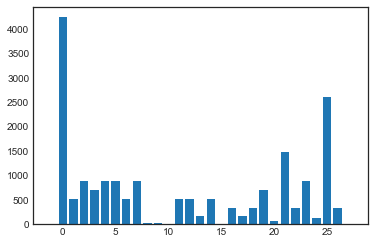

In [30]:
train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
_ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [31]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


# computute confusion matrices between two submission files
def f1_confusion(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
    
    y0avg = np.average(y0,axis=0)
    y1avg = np.average(y1,axis=0)
    cm = [confusion_matrix(y0[:,i], y1[:,i]) for i in range(y0.shape[1])]
    fm = [f1_score(y0[:,i], y1[:,i]) for i in range(y0.shape[1])]
    for i in range(y0.shape[1]):
        print(LABEL_MAP[i])
        print(cm[i],' %4.2f' % fm[i],' %6.4f' % y0avg[i],' %6.4f' % y1avg[i],
             ' %6.4f' % (y0avg[i] - y1avg[i]))
        print()
#     print('y0avg')
#     print(y0avg)
#     print('y1avg')
#     print(y1avg)
#     print('y0avg - y1avg')
#     print(y0avg-y1avg)
    print('f1 macro')
    print(np.mean(fm))       
    return f1_score(y0, y1, average='macro')
    
# compute f1 score between two submission files
def f1_sub(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
            
    return f1_score(y0, y1, average='macro')

# create onehot matrix for a submission file
def onehot_sub(csv0, num_classes=28):
    c0 = pd.read_csv(csv0)
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    p0 = [s.split() for s in s0]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
    # print(y0[:5])
    
    y = pd.DataFrame(y0)
    y.columns = ['y_'+str(i) for i in range(num_classes)]
    
    c0 = pd.concat((c0,y),axis=1)
    
    fname = csv0[:-4] + '_onehot.csv'
    c0.to_csv(fname)      
    print(fname)

In [32]:
# onehot_sub('sub/ens53d.csv')

In [33]:
f1_sub(fname,'sub/ens43.csv')

0.6950541035420762

In [34]:
f1_sub(fname,'sub/ens44.csv')

0.6881195068224384

In [35]:
f1_sub(fname,'sub/ens45.csv')

0.711821057289615

In [36]:
f1_sub(fname,'sub/ens46.csv')

0.6955846655811613

In [37]:
f1_sub(fname,'sub/ens47.csv')

0.6928924430419167

In [38]:
f1_sub(fname,'sub/ens48.csv')

0.6941426803737085

In [39]:
f1_sub(fname,'sub/ens49.csv')

0.6994046056970429

In [40]:
f1_sub(fname,'sub/ens51.csv')

0.699650887064677

In [41]:
f1_sub(fname,'sub/ens53.csv')

0.7855590939312834

In [42]:
f1_sub(fname,'sub/ens53c.csv')

0.7871264909513566

In [43]:
f1_sub(fname,'sub/ens53d.csv')

0.7869577299996202

In [44]:
f1_sub(fname,'sub/ens55.csv')

0.7896965091267276

In [45]:
f1_sub(fname,'sub/ens55d.csv')

0.788695918367741

In [46]:
f1_sub(fname,'sub/ens56.csv')

0.7929118933059273

In [47]:
f1_sub(fname,'sub/ens56d.csv')

0.7930891362035275

In [48]:
f1_sub(fname,'sub/ens58.csv')

0.7974078152463685

In [49]:
f1_sub(fname,'sub/ens58d.csv')

0.7964452730311138

In [50]:
f1_sub(fname,'sub/ens59.csv')

0.7951367115200553

In [51]:
f1_sub(fname,'sub/ens59d.csv')

0.804076302544808

In [52]:
f1_sub(fname,'sub/ens60d.csv')

0.8026987114901948

In [65]:
f1_sub(fname,'sub/ens61.csv')

0.821030006704498

In [53]:
f1_sub(fname,'sub/resnet11.csv')

0.6403917737553426

In [54]:
f1_sub(fname,'sub/resnet12.csv')

0.6673764448834645

In [55]:
f1_sub(fname,'sub/resnet13.csv')

0.6750187535435861

In [56]:
f1_sub(fname,'sub/resnet15.csv')

0.7795252580140384

In [57]:
f1_sub(fname,'sub/resnet15c.csv')

0.774001073197952

In [60]:
f1_sub(fname,'sub/resnet16.csv')

0.6638821274254016

In [62]:
f1_sub(fname,'sub/resnet17.csv')

0.8220520044141765

In [58]:
print(fname)

sub/preresnet0.csv


In [64]:
# f1_confusion(fname, 'sub/resnet15.csv')